In [1]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential


from google.colab import drive
drive.mount('/content/drive')

TensorFlow 1.x selected.


Using TensorFlow backend.


Mounted at /content/drive


In [2]:
tf.set_random_seed(42)

In [3]:
# Standardization
def data_standardization(x):
    x_np = np.asarray(x)
    return (x_np - x_np.mean()) / x_np.std()

# 너무 작거나 너무 큰 값이 학습을 방해하는 것을 방지하고자 정규화한다
# x가 양수라는 가정하에 최소값과 최대값을 이용하여 0~1사이의 값으로 변환
# Min-Max scaling
def min_max_scaling(x):
    x_np = np.asarray(x)
    return (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-7) # 1e-7은 0으로 나누는 오류 예방차원

# 정규화된 값을 원래의 값으로 되돌린다
# 정규화하기 이전의 org_x값과 되돌리고 싶은 x를 입력하면 역정규화된 값을 리턴한다
def reverse_min_max_scaling(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

def z_score_normalize(lst):
    normalized = []

    for value in lst:
        normalized_num = (value - np.mean(lst)) / np.std(lst)
        normalized.append(normalized_num)

    return normalized

def rev_z_score_normalize(org_data, norm_data):
    rev_normalized = norm_data * np.std(org_data, axis = 0) + np.mean(org_data, axis = 0)
    
    return rev_normalized

def MAPE(y_true, y_pred): 
    return np.abs((y_true - y_pred) / y_true) * 100

In [4]:
# 하이퍼파라미터
input_data_column_cnt = 6  # 입력데이터의 컬럼 개수(Variable 개수)
output_data_column_cnt = 1 # 결과데이터의 컬럼 개수

seq_length = 28            # 1개 시퀀스의 길이(시계열데이터 입력 개수)
rnn_cell_hidden_dim = 20   # 각 셀의 (hidden)출력 크기
forget_bias = 1.0          # 망각편향(기본값 1.0)
num_stacked_layers = 1     # stacked LSTM layers 개수
keep_prob = 1              # dropout할 때 keep할 비율

epoch_num = 1000           # 에포크 횟수(학습용전체데이터를 몇 회 반복해서 학습할 것인가 입력)
learning_rate = 0.001       # 학습률

In [5]:
# 데이터를 로딩한다.
# stock_file_name = 'AMZN.csv' # 아마존 주가데이터 파일
stock_file_name = '/content/drive/My Drive/Colab Notebooks/AMZN.csv'
encoding = 'euc-kr' # 문자 인코딩
names = ['Date','Open','High','Low','Close','Adj Close','Volume']
raw_dataframe = pd.read_csv(stock_file_name, names=names, encoding=encoding) #판다스이용 csv파일 로딩
raw_dataframe.info() # 데이터 정보 출력

# raw_dataframe.drop('Date', axis=1, inplace=True) # 시간열을 제거하고 dataframe 재생성하지 않기
del raw_dataframe['Date'] # 위 줄과 같은 효과

stock_info = raw_dataframe.values[1:].astype(np.float) # 금액&거래량 문자열을 부동소수점형으로 변환한다
print("stock_info.shape: ", stock_info.shape)
print("stock_info[0]: ", stock_info[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5179 entries, 0 to 5178
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       5179 non-null   object
 1   Open       5179 non-null   object
 2   High       5179 non-null   object
 3   Low        5179 non-null   object
 4   Close      5179 non-null   object
 5   Adj Close  5179 non-null   object
 6   Volume     5179 non-null   object
dtypes: object(7)
memory usage: 283.4+ KB
stock_info.shape:  (5178, 6)
stock_info[0]:  [2.437500e+00 2.500000e+00 1.927083e+00 1.958333e+00 1.958333e+00
 7.215600e+07]


In [6]:
x = stock_info
print("x.shape: ", x.shape)
print("x[0]: ", x[0])    # x의 첫 값
print("x[-1]: ", x[-1])  # x의 마지막 값
print("="*100) # 화면상 구분용

y = x[:, [-2]] # 타켓은 주식 종가이다
print("y[0]: ",y[0])     # y의 첫 값
print("y[-1]: ",y[-1])   # y의 마지막 값

x.shape:  (5178, 6)
x[0]:  [2.437500e+00 2.500000e+00 1.927083e+00 1.958333e+00 1.958333e+00
 7.215600e+07]
x[-1]:  [1.17040002e+03 1.17275000e+03 1.15709998e+03 1.16200000e+03
 1.16200000e+03 2.71153000e+06]
y[0]:  [1.958333]
y[-1]:  [1162.]


In [7]:
dataX = [] # 입력으로 사용될 Sequence Data
dataY = [] # 출력(타켓)으로 사용

for i in range(0, len(y) - seq_length):
    _x = x[i : i+seq_length]
    _y = y[i + seq_length] # 다음 나타날 주가(정답)
    # if i is 0:
        # print(_x, "->", _y) # 첫번째 행만 출력해 봄      
    dataX.append(_x) # dataX 리스트에 추가
    dataY.append(_y) # dataY 리스트에 추가

print(np.shape(dataX))
print(np.shape(dataY))

(5150, 28, 6)
(5150, 1)


In [8]:
# 학습용/테스트용 데이터 생성
# 전체 70%를 학습용 데이터로 사용
train_size = int(len(dataY) * 0.7)
# 나머지(30%)를 테스트용 데이터로 사용
test_size = len(dataY) - train_size

# 데이터를 잘라 학습용 데이터 생성
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])

# 데이터를 잘라 테스트용 데이터 생성
testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])

print(np.shape(trainX))
print(np.shape(trainY))
print(np.shape(testX))
print(np.shape(testY))

(3604, 28, 6)
(3604, 1)
(1546, 28, 6)
(1546, 1)


In [9]:
# 데이터 전처리
# 가격과 거래량 수치의 차이가 많아나서 각각 별도로 정규화한다

# 가격형태 데이터들을 정규화한다
# ['Open','High','Low','Close','Adj Close','Volume']에서 'Adj Close'까지 취함
# 곧, 마지막 열 Volume를 제외한 모든 열
trainX_price = trainX[:,:,:-1]
testX_price = testX[:,:,:-1]

# 가격형태 데이터 정규화 처리
trainX_norm_price = z_score_normalize(trainX_price) 
testX_norm_price = z_score_normalize(testX_price)
trainY = z_score_normalize(trainY)
testY = z_score_normalize(testY)

print("trainX_price.shape: ", trainX_price.shape)
print("testX_price.shape: ", testX_price.shape)
print("="*100) # 화면상 구분용

# 거래량형태 데이터를 정규화한다
# ['Open','High','Low','Close','Adj Close','Volume']에서 마지막 'Volume'만 취함
# [:,-1]이 아닌 [:,-1:]이므로 주의하자! 스칼라가아닌 벡터값 산출해야만 쉽게 병합 가능
trainX_volume = trainX[:,:,-1:]
testX_volume = testX[:,:,-1:]

# 거래량형태 데이터 정규화 처리
trainX_norm_volume = z_score_normalize(trainX_volume)
testX_norm_volume = z_score_normalize(testX_volume) 
print("trainX_volume.shape: ", trainX_volume.shape)
print("testX_volume.shape: ", testX_volume.shape)
print("="*100) # 화면상 구분용

trainX = np.concatenate((trainX_norm_price, trainX_norm_volume), axis=2) # axis=1, 세로로 합친다
testX = np.concatenate((testX_norm_price, testX_norm_volume), axis=2)
print("trainX.shape: ", trainX.shape)
print("testX.shape: ", testX.shape)
print("="*100) # 화면상 구분용

print("trainY[0]: ",trainY[0])     # trainY의 첫 값
print("trainY[-1]: ",trainY[-1])   # trainY의 마지막 값
print("testY[0]: ",testY[0])       # testY의 첫 값
print("testY[-1]: ",testY[-1])     # testY의 마지막 값

trainX_price.shape:  (3604, 28, 5)
testX_price.shape:  (1546, 28, 5)
trainX_volume.shape:  (3604, 28, 1)
testX_volume.shape:  (1546, 28, 1)
trainX.shape:  (3604, 28, 6)
testX.shape:  (1546, 28, 6)
trainY[0]:  [-1.1647327]
trainY[-1]:  [3.77835299]
testY[0]:  [-0.95008224]
testY[-1]:  [2.55849019]


In [10]:
print(np.shape(dataX))
print(np.shape(dataY))

(5150, 28, 6)
(5150, 1)


In [11]:
# 텐서플로우 플레이스홀더 생성
# 입력 X, 출력 Y를 생성한다
X = tf.placeholder(tf.float32, [None, seq_length, input_data_column_cnt])
print("X: ", X)
Y = tf.placeholder(tf.float32, [None, 1])
print("Y: ", Y)

# 검증용 측정지표를 산출하기 위한 targets, predictions를 생성한다
targets = tf.placeholder(tf.float32, [None, 1])
print("targets: ", targets)

predictions = tf.placeholder(tf.float32, [None, 1])
print("predictions: ", predictions)

X:  Tensor("Placeholder:0", shape=(?, 28, 6), dtype=float32)
Y:  Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)
targets:  Tensor("Placeholder_2:0", shape=(?, 1), dtype=float32)
predictions:  Tensor("Placeholder_3:0", shape=(?, 1), dtype=float32)


In [12]:
# 모델(LSTM 네트워크) 생성
def lstm_cell():
    # LSTM셀을 생성
    # num_units: 각 Cell 출력 크기
    # forget_bias:  to the biases of the forget gate 
    #              (default: 1)  in order to reduce the scale of forgetting in the beginning of the training.
    # state_is_tuple: True ==> accepted and returned states are 2-tuples of the c_state and m_state.
    # state_is_tuple: False ==> they are concatenated along the column axis.
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_cell_hidden_dim, 
                                        forget_bias=forget_bias, state_is_tuple=True, activation=tf.nn.leaky_relu)
    if keep_prob < 1.0:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell

# num_stacked_layers개의 층으로 쌓인 Stacked RNNs 생성
stackedRNNs = [lstm_cell() for _ in range(num_stacked_layers)]
multi_cells = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_stacked_layers > 1 else lstm_cell()

# RNN Cell(여기서는 LSTM셀임)들을 연결
hypothesis, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)
print("hypothesis: ", hypothesis)

# [:, -1]를 잘 살펴보자. LSTM RNN의 마지막 (hidden)출력만을 사용했다.
# 과거 여러 거래일의 주가를 이용해서 다음날의 주가 1개를 예측하기때문에 MANY-TO-ONE형태이다
# hypothesis = tf.contrib.layers.fully_connected(hypothesis[:, -1], output_data_column_cnt, activation_fn=tf.identity)
hypothesis = tf.contrib.layers.fully_connected(hypothesis[:, -1], output_data_column_cnt, activation_fn=tf.identity)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
hypothesis:  Tensor("rnn/transpose_1:0", shape=(?, 28, 20), dtype=float32)
Instructions for updating:
Please use `layer.__call__` method instead.


In [13]:
# 손실함수로 평균제곱오차를 사용한다
loss = tf.reduce_sum(tf.square(hypothesis - Y))
# 최적화함수로 AdamOptimizer를 사용한다
optimizer = tf.train.AdamOptimizer(learning_rate)
# optimizer = tf.train.RMSPropOptimizer(learning_rate) # LSTM과 궁합 별로임

train = optimizer.minimize(loss)

# RMSE(Root Mean Square Error)
# 제곱오차의 평균을 구하고 다시 제곱근을 구하면 평균 오차가 나온다
# rmse = tf.sqrt(tf.reduce_mean(tf.square(targets-predictions))) # 아래 코드와 같다
rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predictions)))

In [14]:
train_error_summary = [] # 학습용 데이터의 오류를 중간 중간 기록한다
test_error_summary = []  # 테스트용 데이터의 오류를 중간 중간 기록한다
test_predict = ''        # 테스트용데이터로 예측한 결과

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# 학습한다
start_time = datetime.datetime.now() # 시작시간을 기록한다
print('학습을 시작합니다...')
for epoch in range(epoch_num):
    _, _loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
    if ((epoch+1) % 100 == 0) or (epoch == epoch_num-1): # 100번째마다 또는 마지막 epoch인 경우
        # 학습용데이터로 rmse오차를 구한다
        train_predict = sess.run(hypothesis, feed_dict={X: trainX})
        train_error = sess.run(rmse, feed_dict={targets: trainY, predictions: train_predict})
        train_error_summary.append(train_error)

        # 테스트용데이터로 rmse오차를 구한다
        test_predict = sess.run(hypothesis, feed_dict={X: testX})
        test_error = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
        test_error_summary.append(test_error)
        
        # 현재 오류를 출력한다
        print("epoch: {}, train_error(A): {}, test_error(B): {}, B-A: {}".format(epoch+1, train_error, test_error, test_error-train_error))
        
end_time = datetime.datetime.now() # 종료시간을 기록한다
elapsed_time = end_time - start_time # 경과시간을 구한다
print('elapsed_time:',elapsed_time)
print('elapsed_time per epoch:',elapsed_time/epoch_num)

학습을 시작합니다...
epoch: 100, train_error(A): 0.17068682610988617, test_error(B): 0.18683236837387085, B-A: 0.01614554226398468
epoch: 200, train_error(A): 0.09391117841005325, test_error(B): 0.09031841158866882, B-A: -0.00359276682138443
epoch: 300, train_error(A): 0.08021525293588638, test_error(B): 0.07039835304021835, B-A: -0.00981689989566803
epoch: 400, train_error(A): 0.07727552205324173, test_error(B): 0.0675618126988411, B-A: -0.009713709354400635
epoch: 500, train_error(A): 0.07548420131206512, test_error(B): 0.06635429710149765, B-A: -0.009129904210567474
epoch: 600, train_error(A): 0.07399144768714905, test_error(B): 0.06533420085906982, B-A: -0.008657246828079224
epoch: 700, train_error(A): 0.07257804274559021, test_error(B): 0.06414515525102615, B-A: -0.008432887494564056
epoch: 800, train_error(A): 0.07117244601249695, test_error(B): 0.06277752667665482, B-A: -0.008394919335842133
epoch: 900, train_error(A): 0.06913100183010101, test_error(B): 0.06113414093852043, B-A: -0.007

In [15]:
np.shape(testX)
print(np.shape(test_predict))

(1546, 1)


input_data_column_cnt: 6,output_data_column_cnt: 1,seq_length: 28,rnn_cell_hidden_dim: 20,forget_bias: 1.0,num_stacked_layers: 1,keep_prob: 1,epoch_num: 1000,learning_rate: 0.001,train_error: 0.066988006,test_error: 0.060458537,min_test_error: 0.060458537


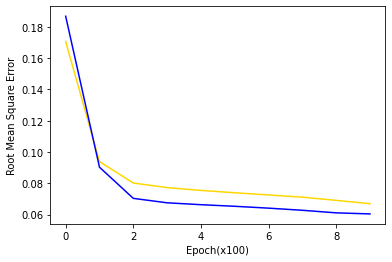

<Figure size 432x288 with 0 Axes>

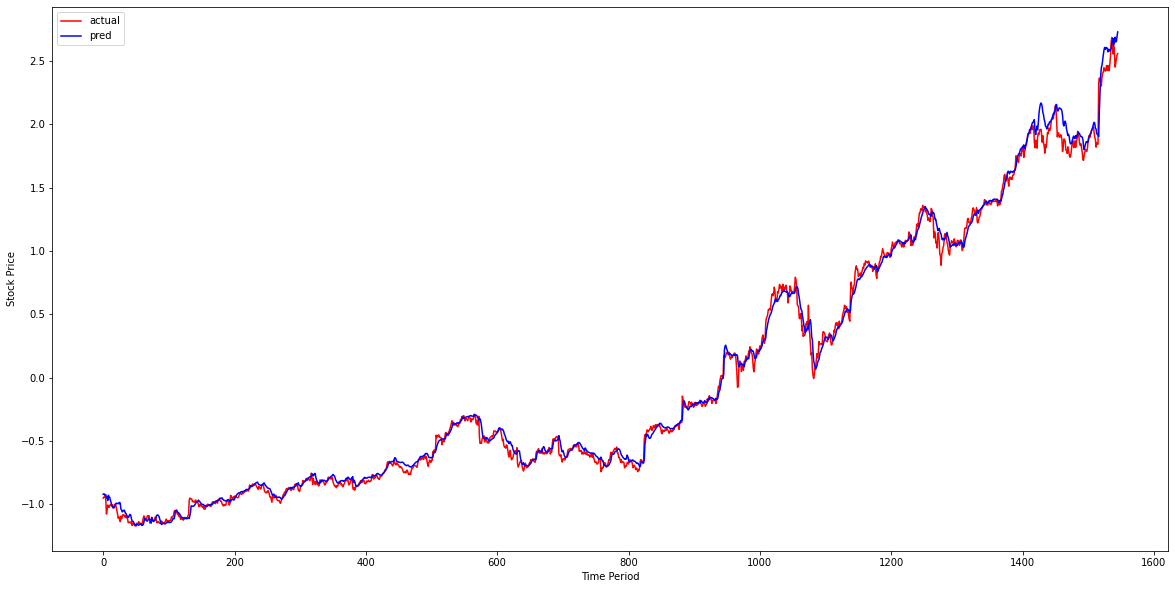

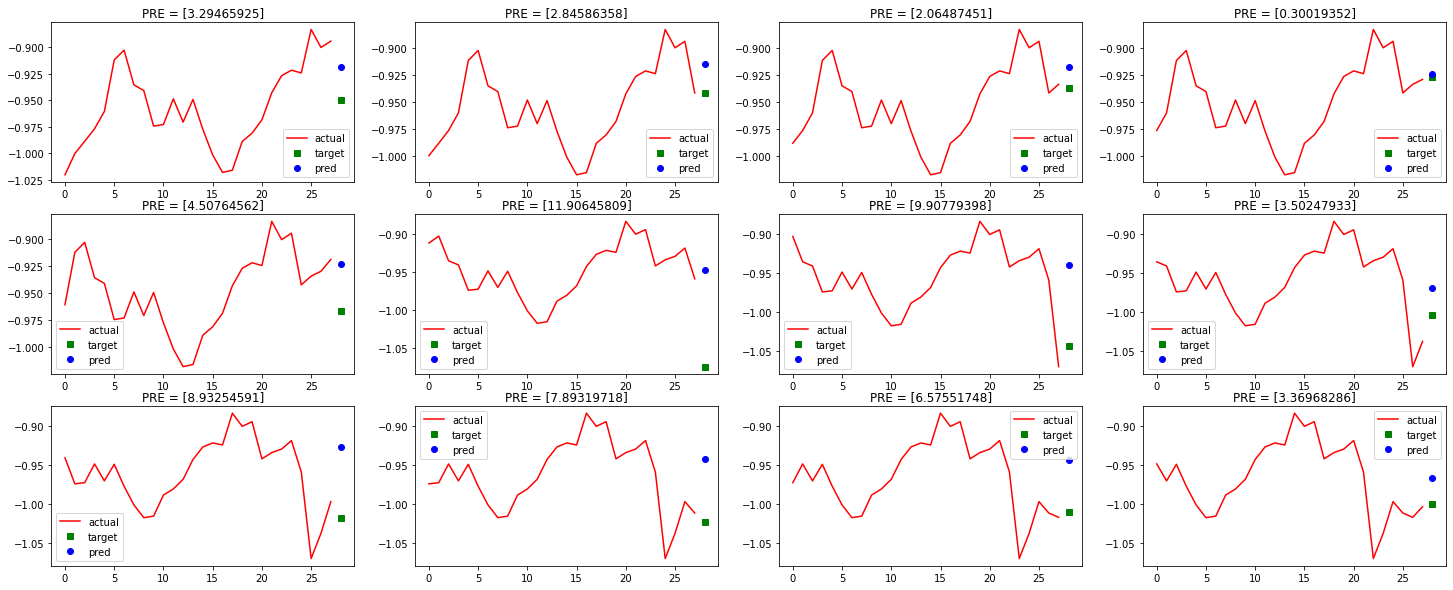

In [16]:
# 하이퍼파라미터 출력
print('input_data_column_cnt:', input_data_column_cnt, end='')
print(',output_data_column_cnt:', output_data_column_cnt, end='')

print(',seq_length:', seq_length, end='')
print(',rnn_cell_hidden_dim:', rnn_cell_hidden_dim, end='')
print(',forget_bias:', forget_bias, end='')
print(',num_stacked_layers:', num_stacked_layers, end='')
print(',keep_prob:', keep_prob, end='')

print(',epoch_num:', epoch_num, end='')
print(',learning_rate:', learning_rate, end='')

print(',train_error:', train_error_summary[-1], end='')
print(',test_error:', test_error_summary[-1], end='')
print(',min_test_error:', np.min(test_error_summary))

# 결과 그래프 출력
plt.figure(1)
plt.plot(train_error_summary, 'gold')
plt.plot(test_error_summary, 'b')
plt.xlabel('Epoch(x100)')
plt.ylabel('Root Mean Square Error')


plt.figure(2)
plt.figure(figsize = (20,10))
plt.plot(testY, 'r', label='actual')
plt.plot(test_predict, 'b', label='pred')
# plt.xlim(1350,1550)
# plt.ylim(0.7, 3)
plt.xlabel('Time Period')
plt.ylabel('Stock Price')
plt.legend()


plt.figure(figsize = (25,10))
for i in range(0,12):
    plots = plt.subplot(3, 4, i + 1)
    PRE = MAPE(testY[i], test_predict[i])
    plt.plot(testX[i,:,-2], 'r', label='actual')
    plt.plot(28,testY[i], 'gs', label='target')
    plt.plot(28,test_predict[i], 'bo', label='pred')
    plt.title('PRE = {}'.format(PRE))
    plt.legend()

plt.show()

In [17]:
# sequence length만큼의 가장 최근 데이터를 슬라이싱한다
recent_data = np.array([testX[len(testX)-seq_length , :, :]])
print("recent_data.shape:", recent_data.shape)

# 내일 종가를 예측해본다
test_predict = sess.run(hypothesis, feed_dict={X: recent_data})

print("test_predict", test_predict)
test_predict = rev_z_score_normalize(testX_price,test_predict) # 금액데이터 역정규화한다
print("Tomorrow's stock price", test_predict) # 예측한 주가를 출력한다

recent_data.shape: (1, 28, 6)
test_predict [[2.2389967]]
Tomorrow's stock price [[1031.15513837 1038.12658705 1022.44707015 1030.69907388 1030.69907388]
 [1032.73309303 1039.68610949 1024.01829728 1032.2589604  1032.2589604 ]
 [1034.28564502 1041.23403076 1025.5650115  1033.81149642 1033.81149642]
 [1035.80853718 1042.75015682 1027.07015954 1035.3215296  1035.3215296 ]
 [1037.30079147 1044.31140673 1028.57922674 1036.90366445 1036.90366445]
 [1038.86791821 1045.92453528 1030.17407973 1038.52351115 1038.52351115]
 [1040.50051229 1047.56489244 1031.80624174 1040.15825667 1040.15825667]
 [1042.12661073 1049.22431947 1033.44487138 1041.83225678 1041.83225678]
 [1043.76402067 1050.85108001 1035.06276342 1043.47905101 1043.47905101]
 [1045.39291885 1052.4819062  1036.71256785 1045.10348188 1045.10348188]
 [1046.9964638  1054.13497085 1038.34053657 1046.73330715 1046.73330715]
 [1048.62280085 1055.77151811 1039.97041061 1048.39202577 1048.39202577]
 [1050.23612667 1057.38049182 1041.58733456 

In [18]:
# sequence length만큼의 가장 최근 데이터를 슬라이싱한다
recent_data = np.array([x[len(x)-seq_length : ]])
print("recent_data.shape:", recent_data.shape)
print("recent_data:", recent_data)

# 내일 종가를 예측해본다
test_predict = sess.run(hypothesis, feed_dict={X: recent_data})

print("test_predict", test_predict[0])
test_predict = reverse_min_max_scaling(testX_price,test_predict) # 금액데이터 역정규화한다
print("Tomorrow's stock price", test_predict[0]) # 예측한 주가를 출력한다

recent_data.shape: (1, 28, 6)
recent_data: [[[1.10900000e+03 1.11054004e+03 1.10112000e+03 1.10528003e+03
   1.10528003e+03 3.47700000e+06]
  [1.10540002e+03 1.10896997e+03 1.09673999e+03 1.10368005e+03
   1.10368005e+03 3.75550000e+06]
  [1.09781006e+03 1.10193994e+03 1.08687000e+03 1.09421997e+03
   1.09421997e+03 3.68490000e+06]
  [1.09115002e+03 1.11268005e+03 1.08852002e+03 1.11159998e+03
   1.11159998e+03 3.75150000e+06]
  [1.10915002e+03 1.12541003e+03 1.10877002e+03 1.12066003e+03
   1.12066003e+03 3.38110000e+06]
  [1.12473999e+03 1.13059998e+03 1.11750000e+03 1.12317004e+03
   1.12317004e+03 2.68900000e+06]
  [1.12281995e+03 1.13554004e+03 1.11910999e+03 1.13288000e+03
   1.13288000e+03 2.58150000e+06]
  [1.12595996e+03 1.12962000e+03 1.11577002e+03 1.12913000e+03
   1.12913000e+03 3.73270000e+06]
  [1.12609998e+03 1.13175000e+03 1.12406006e+03 1.12534998e+03
   1.12534998e+03 2.17990000e+06]
  [1.12300000e+03 1.13990002e+03 1.12233997e+03 1.12917004e+03
   1.12917004e+03 2.9

In [19]:
###############
# Differencing 
###############

# Non-stationary -> stationary
# Defferencing

def diff(non_stationary_data):
    stationary_data = []

    for i in range(0, len(non_stationary_data)-1):
        stationary_data_num = non_stationary_data[i+1] - non_stationary_data[i] 
        stationary_data.append(stationary_data_num)
    
    return np.asarray(stationary_data)

def rev_diff(predict_diff_data, org_data):
    pred_data = [org_data[0]]

    for i in range(0, len(predict_diff_data)):
        pred_data_num = predict_diff_data[i] + org_data[i]
        pred_data.append(pred_data_num)
    
    return np.asarray(pred_data)


def PercentageError(y_true, y_pred): 
    return ((y_true - y_pred) / y_true) * 100

In [20]:
# 하이퍼파라미터
input_data_column_cnt = 6  # 입력데이터의 컬럼 개수(Variable 개수)
output_data_column_cnt = 1 # 결과데이터의 컬럼 개수

seq_length = 28            # 1개 시퀀스의 길이(시계열데이터 입력 개수)
rnn_cell_hidden_dim = 20   # 각 셀의 (hidden)출력 크기
forget_bias = 1.0          # 망각편향(기본값 1.0)
num_stacked_layers = 1     # stacked LSTM layers 개수
keep_prob = 1              # dropout할 때 keep할 비율

epoch_num = 3000           # 에포크 횟수(학습용전체데이터를 몇 회 반복해서 학습할 것인가 입력)
learning_rate = 0.0001       # 학습률

In [21]:
# 데이터를 로딩한다.
# stock_file_name = 'AMZN.csv' # 아마존 주가데이터 파일
stock_file_name = '/content/drive/My Drive/Colab Notebooks/AMZN.csv'
encoding = 'euc-kr' # 문자 인코딩
names = ['Date','Open','High','Low','Close','Adj Close','Volume']
raw_dataframe = pd.read_csv(stock_file_name, names=names, encoding=encoding) #판다스이용 csv파일 로딩
raw_dataframe.info() # 데이터 정보 출력

# raw_dataframe.drop('Date', axis=1, inplace=True) # 시간열을 제거하고 dataframe 재생성하지 않기
del raw_dataframe['Date'] # 위 줄과 같은 효과

stock_info = raw_dataframe.values[1:].astype(np.float) # 금액&거래량 문자열을 부동소수점형으로 변환한다
print("stock_info.shape: ", stock_info.shape)
print("stock_info[0]: ", stock_info[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5179 entries, 0 to 5178
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       5179 non-null   object
 1   Open       5179 non-null   object
 2   High       5179 non-null   object
 3   Low        5179 non-null   object
 4   Close      5179 non-null   object
 5   Adj Close  5179 non-null   object
 6   Volume     5179 non-null   object
dtypes: object(7)
memory usage: 283.4+ KB
stock_info.shape:  (5178, 6)
stock_info[0]:  [2.437500e+00 2.500000e+00 1.927083e+00 1.958333e+00 1.958333e+00
 7.215600e+07]


In [22]:
dataX = [] # 입력으로 사용될 Sequence Data
dataY = [] # 출력(타켓)으로 사용

for i in range(0, len(y) - seq_length):
    _x = x[i : i+seq_length]
    _y = y[i + seq_length] # 다음 나타날 주가(정답)
    # if i is 0:
        # print(_x, "->", _y) # 첫번째 행만 출력해 봄      
    dataX.append(_x) # dataX 리스트에 추가
    dataY.append(_y) # dataY 리스트에 추가

print(np.shape(dataX))
print(np.shape(dataY))

(5150, 28, 6)
(5150, 1)


In [23]:
# 학습용/테스트용 데이터 생성
# 전체 70%를 학습용 데이터로 사용
train_size = int(len(dataY) * 0.7)
# 나머지(30%)를 테스트용 데이터로 사용
test_size = len(dataY) - train_size

# 데이터를 잘라 학습용 데이터 생성
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])

# 데이터를 잘라 테스트용 데이터 생성
testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])

print(np.shape(trainX))
print(np.shape(trainY))
print(np.shape(testX))
print(np.shape(testY))

(3604, 28, 6)
(3604, 1)
(1546, 28, 6)
(1546, 1)


In [24]:
trainX_price = trainX[:,:,:-1]
testX_price = testX[:,:,:-1]
realvalue_trainY = trainY
realvalue_testY = testY

# 가격형태 데이터 정규화 처리
trainX_norm_price = z_score_normalize(trainX_price) 
testX_norm_price = z_score_normalize(testX_price)

print("trainX_price.shape: ", trainX_price.shape)
print("testX_price.shape: ", testX_price.shape)
print("="*50) # 화면상 구분용

# 거래량형태 데이터를 정규화한다
trainX_volume = trainX[:,:,-1:]
testX_volume = testX[:,:,-1:]

# 거래량형태 데이터 정규화 처리
trainX_norm_volume = z_score_normalize(trainX_volume)
testX_norm_volume = z_score_normalize(testX_volume) 
print("trainX_volume.shape: ", trainX_volume.shape)
print("testX_volume.shape: ", testX_volume.shape)
print("="*50) # 화면상 구분용

trainX_price.shape:  (3604, 28, 5)
testX_price.shape:  (1546, 28, 5)
trainX_volume.shape:  (3604, 28, 1)
testX_volume.shape:  (1546, 28, 1)


In [25]:
org_trainX = np.concatenate((trainX_norm_price, trainX_norm_volume), axis=2) # axis=1, 세로로 합친다
org_testX = np.concatenate((testX_norm_price, testX_norm_volume), axis=2)
print("trainX.shape: ", trainX.shape)
print("testX.shape: ", testX.shape)
print("="*50) # 화면상 구분용

org_trainY = z_score_normalize(trainY)
org_testY = z_score_normalize(testY)

print("trainY.shape: ", np.shape(trainY))
print("testY.shape: ", np.shape(testY))
print("="*50) # 화면상 구분용
print("trainY[0]: ",trainY[0])     # trainY의 첫 값
print("trainY[-1]: ",trainY[-1])   # trainY의 마지막 값
print("testY[0]: ",testY[0])       # testY의 첫 값
print("testY[-1]: ",testY[-1])     # testY의 마지막 값

trainX.shape:  (3604, 28, 6)
testX.shape:  (1546, 28, 6)
trainY.shape:  (3604, 1)
testY.shape:  (1546, 1)
trainY[0]:  [1.510417]
trainY[-1]:  [243.880005]
testY[0]:  [231.529999]
testY[-1]:  [1162.]


In [26]:
# Non-stationary -> stationary
# Differencing

trainX = diff(org_trainX)
trainY = diff(org_trainY)
testX = diff(org_testX)
testY = diff(org_testY)

print('trainX.shape: ', np.shape(trainX))
print('trainY.shape: ', np.shape(trainY))
print('testX.shape: ', np.shape(testX))
print('testY.shape: ', np.shape(testY))


trainX.shape:  (3603, 28, 6)
trainY.shape:  (3603, 1)
testX.shape:  (1545, 28, 6)
testY.shape:  (1545, 1)


In [27]:
# 텐서플로우 플레이스홀더 생성
# 입력 X, 출력 Y를 생성한다
X = tf.placeholder(tf.float32, [None, seq_length, input_data_column_cnt])
print("X: ", X)
Y = tf.placeholder(tf.float32, [None, 1])
print("Y: ", Y)

# 검증용 측정지표를 산출하기 위한 targets, predictions를 생성한다
targets = tf.placeholder(tf.float32, [None, 1])
print("targets: ", targets)

predictions = tf.placeholder(tf.float32, [None, 1])
print("predictions: ", predictions)

X:  Tensor("Placeholder:0", shape=(?, 28, 6), dtype=float32)
Y:  Tensor("Placeholder_5:0", shape=(?, 1), dtype=float32)
targets:  Tensor("Placeholder_6:0", shape=(?, 1), dtype=float32)
predictions:  Tensor("Placeholder_7:0", shape=(?, 1), dtype=float32)


In [30]:
#아래의 코드는 Differencing 코드이며, 동일한 Tensor 모델이 위와 중복되므로, 현재셀 실행시 오류 발생.
#다른 코랩에 옮겨 따로 실행시 정상 실행됨  


# # 모델(LSTM 네트워크) 생성
# def lstm_cell():
#     cell = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_cell_hidden_dim, 
#                                         forget_bias=forget_bias, state_is_tuple=True, activation=tf.nn.leaky_relu)
#     if keep_prob < 1.0:
#         cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
#     return cell

# # num_stacked_layers개의 층으로 쌓인 Stacked RNNs 생성
# stackedRNNs = [lstm_cell() for _ in range(num_stacked_layers)]
# multi_cells = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_stacked_layers > 1 else lstm_cell()

# # RNN Cell(여기서는 LSTM셀임)들을 연결
# hypothesis, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)
# print("hypothesis: ", hypothesis)

# # [:, -1]를 잘 살펴보자. LSTM RNN의 마지막 (hidden)출력만을 사용했다.
# # 과거 여러 거래일의 주가를 이용해서 다음날의 주가 1개를 예측하기때문에 MANY-TO-ONE형태이다
# # hypothesis = tf.contrib.layers.fully_connected(hypothesis[:, -1], output_data_column_cnt, activation_fn=tf.identity)
# hypothesis = tf.contrib.layers.fully_connected(hypothesis[:, -1], output_data_column_cnt, activation_fn=tf.identity)

# trainX = org_trainX
# trainY = org_trainY
# testX = org_testX
# testY = org_testY[:-1]
# test_predict = rev_diff(test_predict, org_testY)


# print('test_predict.shape: ', np.shape(test_predict))
# print('testY.shape: ', np.shape(testY))

# # 하이퍼파라미터 출력
# print('input_data_column_cnt:', input_data_column_cnt, end='')
# print(',output_data_column_cnt:', output_data_column_cnt, end='')

# print(',seq_length:', seq_length, end='')
# print(',rnn_cell_hidden_dim:', rnn_cell_hidden_dim, end='')
# print(',forget_bias:', forget_bias, end='')
# print(',num_stacked_layers:', num_stacked_layers, end='')
# print(',keep_prob:', keep_prob, end='')

# print(',epoch_num:', epoch_num, end='')
# print(',learning_rate:', learning_rate, end='')

# print(',train_error:', train_error_summary[-1], end='')
# print(',test_error:', test_error_summary[-1], end='')
# print(',min_test_error:', np.min(test_error_summary))

# # 결과 그래프 출력
# plt.figure(1)
# plt.plot(train_error_summary, 'gold')
# plt.plot(test_error_summary, 'b')
# plt.xlabel('Epoch(x100)')
# plt.ylabel('Root Mean Square Error')


# plt.figure(2)
# plt.figure()
# plt.plot(testY, 'r', label='actual')
# plt.plot(test_predict, 'b', label='pred')
# # plt.xlim(0,200)
# # plt.ylim(-2, 2)
# plt.xlabel('Time Period')
# plt.ylabel('Stock Price')
# plt.legend()
